In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from matplotlib.animation import FuncAnimation
import numpy as np
from shapely import geometry
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(color_codes=True)
from mpl_toolkits.basemap import Basemap
import geopandas as gdp
from matplotlib import interactive
plt.style.use('bmh')
interactive(True)

In [3]:
df_dist_d = gdp.read_file('/Users/tjspross/Downloads/layer0_0_dense/')
df_dist_d = df_dist_d.to_crs({'init': 'epsg:4326'})
df_dist_c = gdp.read_file('/Users/tjspross/Downloads/layer0_0_central/')
df_dist_c = df_dist_c.to_crs({'init': 'epsg:4326'})

df_natline = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/natural_line.shp')
df_bound_line = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_line.shp')
df_highway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/highway_line.shp')
df_waterway = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/waterway_polygon_polygon.shp')
df_bound_poly = gdp.read_file('/Users/tjspross/Documents/shanghai_sharpfile/boundary_polygon_polygon.shp')
df_bound_poly = df_bound_poly.loc[df_bound_poly['BOUNDARY']!='protected_area']
df_bound_poly = df_bound_poly.loc[df_bound_poly['ADMIN_LEVE']=='6']

In [4]:
df = pd.read_json("/Users/tjspross/Documents/scrapy_smartshanghai/housing.json",lines=True)
# remove null or missing values
df = df.loc[~df['title'].isnull()]
df.loc[df['rooms']!='']

# filter by apartment types
df = df.loc[df['posted_type'].isin(['Apartment for rent','Shared apartment','House for rent','Service Apartment'])]

# truncate publish_time column into dates and months
df['publish_date'] = df['publish_time'].dt.date
df['publish_month'] = pd.to_datetime(dict(year=df['publish_time'].dt.year, month=df['publish_time'].dt.month, day=1))
df['pub_month'] = df['publish_month'].dt.month
df['publish_week']=(df['publish_time'] - pd.to_timedelta(df['publish_time'].dt.dayofweek, unit='d')).dt.date
# show dataframe

#create rooms columns
df['rooms'] = df['rooms'].str.replace(', [0-9]* Storage','').str.strip()
df['rooms_BR'] = df['rooms'].str.extract('([0-9]*) Bedroom',0).fillna(0).astype('int')
df['rooms_BA'] = df['rooms'].str.extract('.*, ([0-9]*) Bathroom',0).fillna(0).astype('int')

df['rooms_simple'] = df['rooms_BR'].astype('str') + "BR, "+ df['rooms_BA'].astype('str') + "BA"

# filter for prices like 10,000 RMB or 10,000 rmb or 10,000 or RMB10,000
df = df.loc[df['price'].str.contains('^[0-9,]{3,} RMB$|^[0-9,]{3,} rmb$|^[0-9,]{3,}$|^RMB[0-9,]{3,}$')]
# strip unnecessary characters and convert to int
df['price']=df['price'].str.replace('RMB', '', case=True).str.replace(',','').str.strip().astype('int')


# remove sublets that appear in 'Apartments for rent'
sublets = df.loc[(df['description'].str.contains('overtake|leaving|take over|sublet|roommate|roomate|bedroom available')) & 
             (df['posted_type']=='Apartment for rent') &
            (df['rooms_BR']>=2) &
            (df['price']<10000)][['description','price','rooms','posted_type']]
sublets4= df.loc[(df['rooms_BR']>=4) & (df['price']<=8000) & (df['posted_type']=='Apartment for rent')]
sublets3= df.loc[(df['rooms_BR']==3) & (df['price']<=5000) & (df['posted_type']=='Apartment for rent')]

df = df.loc[~df.index.isin(sublets4.index)]
df = df.loc[~df.index.isin(sublets3.index)]
df = df.loc[~df.index.isin(sublets.index)]

for i in xrange(0,4):
    # filtering out top 1% apartments 
    upper_lim = df.loc[df['rooms_BR']==i]['price'].quantile(0.99)
    df = df.loc[~((df['price']>upper_lim) & (df['rooms_BR']==i))]

# filtering out 4 bedrooms more than 70,000 RMB and less tahn 8000 RMB. This analysis does not concern luxury apartments
df = df.loc[~((df['price']<8000) & (df['rooms_BR']==4))]
df = df.loc[~((df['price']>=70000) & (df['rooms_BR']==4))]
# filtering out 3 bedrooms less than 7000, 6000 seems to be a better cutoff
df = df.loc[~((df['price']>=50000) & (df['rooms_BR']==3))]
df = df.loc[~((df['price']<7000) & (df['rooms_BR']==3))]
# filtering out 2 bedrooms less than 4500, there are some 2BR in Jiading or Putuo for 4500 or 5k
df = df.loc[~((df['price']<4500) & (df['rooms_BR']==2))]
df = df.loc[~((df['price']>=30000) & (df['rooms_BR']==2))]

# Clean size column
df.set_value(df['size']=='sqm','size',None)
temp=df['size'].str.extract('([0-9]*)\+|([0-9]*)\.|([0-9]*) sqm',expand=False).replace(' ',np.nan).replace('',np.nan).fillna(0)
df['size_int']= temp.astype('int').sum(axis=1)
df.set_value(df['size_int']==0,'size_int',np.nan)
# filter for obscenely small and large apartments
df = df.loc[(df['size_int']>=15) &(df['size_int']<=300)]

# Define columns
main_cols = ['area','author','description','floor','latitude',
             'longitude','listing_id','posted_type','price','publish_time','rooms','size','title']
checkbox_cols = ['air_filter','central_aircon','balcony','dryer','dvd_player','elevator',
                 'floor_heating','health_club','outdoor_space','oven','parking','playground','pool',
                'security','tv','wall_heating','washing_machine','water_filter']

# Show weeks in which we pulled the most data
weeks = df['publish_week'].value_counts()[0:6].index
weeks = weeks.sort_values()

df = df.loc[df['longitude'].astype('str') !='']
df = df.loc[df['latitude'].astype('str')!='']

In [5]:
def checkarea(value,geoDataFrame):
    area = geoDataFrame.loc[geoDataFrame['geometry'].contains(geometry.Point(value[0],value[1]))]['TITLE']
    if area.empty:
        return None
    else:
        return area.tolist()[0]
# df['district'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist,),axis=1)
df['district_dense'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_d,),axis=1)
df['district_central'] = df[['longitude','latitude']].astype('float').apply(checkarea,args=(df_dist_c,),axis=1)

In [6]:
def makegeoseris(value):
    return geometry.Point(value[0],value[1])
df['geometry']=df[['longitude','latitude']].astype('float').apply(makegeoseris,axis=1)
dfgeo = gdp.GeoDataFrame(df)

In [7]:
def count_points(geoDataframe,groupby_col=None,output_col=None):
    counts=pd.DataFrame(geoDataframe.loc[~geoDataframe[groupby_col].isnull()][groupby_col].value_counts())
    counts.columns=[output_col]
    counts['TITLE']=counts.index
    counts.set_index("TITLE")
    return counts[output_col]
df_dist_d = df_dist_d.filter(regex='^(?!count)')
df_dist_c = df_dist_c.filter(regex='^(?!count)')
if df_dist_c.filter(regex='count').empty:
    df_dist_c = df_dist_c.join(count_points(dfgeo,'district_central','count'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_central','count_1br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_central','count_2br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_central','count_3br'),on='TITLE')
    df_dist_c = df_dist_c.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_central','count_4br'),on='TITLE')
if df_dist_d.filter(regex='count').empty:
    df_dist_d = df_dist_d.join(count_points(dfgeo,'district_dense','count'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==1],'district_dense','count_1br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==2],'district_dense','count_2br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==3],'district_dense','count_3br'),on='TITLE')
    df_dist_d = df_dist_d.join(count_points(dfgeo.loc[dfgeo['rooms_BR']==4],'district_dense','count_4br'),on='TITLE')

In [8]:
def agg_price(func,rooms_br=None,groupby_col=None):
    if callable(func):
        func_name=func.__name__
    else:
        func_name=func
    price = pd.DataFrame(dfgeo.loc[
    (dfgeo['rooms_BR']==rooms_br) &
    (~dfgeo['posted_type'].isin(['Shared apartment','Service Apartment']))].groupby(groupby_col).agg(func)['price'])
    colname = "%s_%sbr"% (func_name,rooms_br)
    price.columns=[colname]
    price['TITLE']=price.index
    price[colname + "_text"] = price.apply(lambda x: "{:,.0f} CNY".format(np.round(x[colname]),0), axis=1)
    price=price.set_index('TITLE')
    return price
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def calc_price_cols(geoDataframe,groupby_col=None):
    if geoDataframe.filter(regex='median').empty:
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('median',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='mean').empty:
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price('mean',rooms_br=4,groupby_col=groupby_col),on='TITLE')
    if geoDataframe.filter(regex='quant').empty:
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=1,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=2,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=3,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(10),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(25),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(75),rooms_br=4,groupby_col=groupby_col),on='TITLE')
        geoDataframe = geoDataframe.join(agg_price(percentile(90),rooms_br=4,groupby_col=groupby_col),on='TITLE')
    return geoDataframe

df_dist_c = calc_price_cols(df_dist_c.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_central')
df_dist_d = calc_price_cols(df_dist_d.filter(regex='^(?!mean|median|percentile)'),groupby_col='district_dense')

/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [9]:
elev = df.groupby('district_dense')['elevator'].agg(['sum','count'])
elev['perc_elev'] = elev['sum']/elev['count']

df_dist_c = df_dist_c.loc[:, df_dist_c.columns != 'perc_elev'].join(elev['perc_elev'],on='TITLE')
df_dist_c['perc_laofang'] = 1-df_dist_c['perc_elev']
df_dist_d = df_dist_d.loc[:, df_dist_d.columns != 'perc_elev'].join(elev['perc_elev'],on='TITLE')
df_dist_d['perc_laofang'] = 1-df_dist_d['perc_elev']
df_dist_d['perc_laofang_text'] = df_dist_d['perc_laofang'].apply(lambda x: "{} %".format(100*np.round(x,3), axis=1))

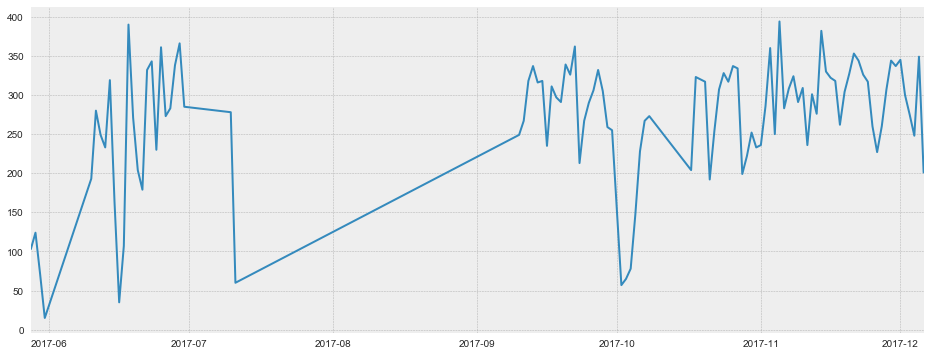

In [19]:
plt.figure(figsize=(16,6))
df.publish_date.value_counts().plot()
plt.show()

In [10]:
def round_and_combine(value):
    return tuple(np.round(value,3))
df['lat_long'] = df[['latitude', 'longitude']].apply(round_and_combine, axis=1)
df['lat_long'].value_counts()

TypeError: ("can't multiply sequence by non-int of type 'float'", u'occurred at index 0')

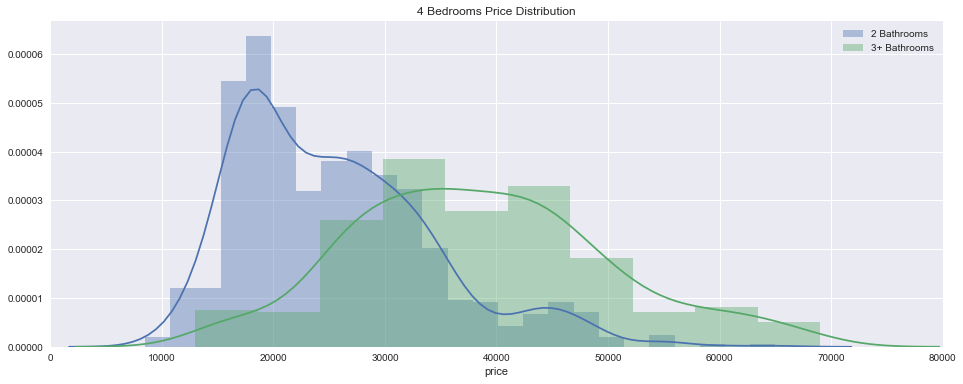

In [60]:
plt.figure(figsize=(16,6))
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==1) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms') 
sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>=3) & (df['price']<80000) &
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=10,label='3+ Bathrooms')
# sns.distplot(df.loc[(df['rooms_BR']==4) & (df['rooms_BA']>3) & 
#                     (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
#              bins=50,label='4+ Bathrooms')
plt.title("4 Bedrooms Price Distribution")

plt.legend()
plt.xlim(0,80000)
plt.show()

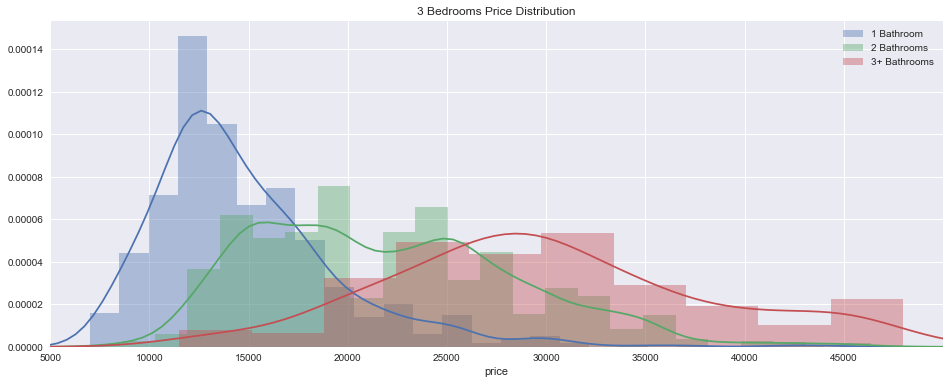

In [62]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
sns.distplot(df.loc[(df['rooms_BR']==3) & (df['rooms_BA']>2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=10,label='3+ Bathrooms')
plt.title("3 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(5000,50000,5000))
plt.xlim(5000,50000)
plt.show()

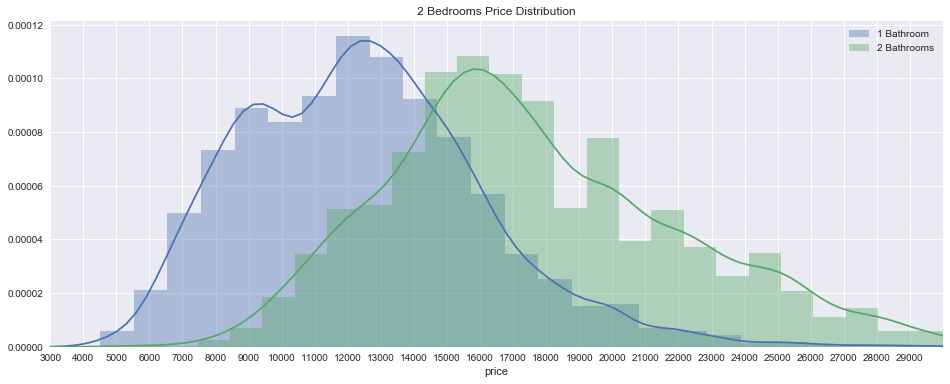

In [53]:
plt.figure(figsize=(16,6))
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==1) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='1 Bathroom')
sns.distplot(df.loc[(df['rooms_BR']==2) & (df['rooms_BA']==2) & 
                    (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],
             bins=25,label='2 Bathrooms')
plt.title("2 Bedrooms Price Distribution")
plt.legend()
plt.xticks(np.arange(3000,30000,1000))
plt.xlim(3000,30000)
plt.show()

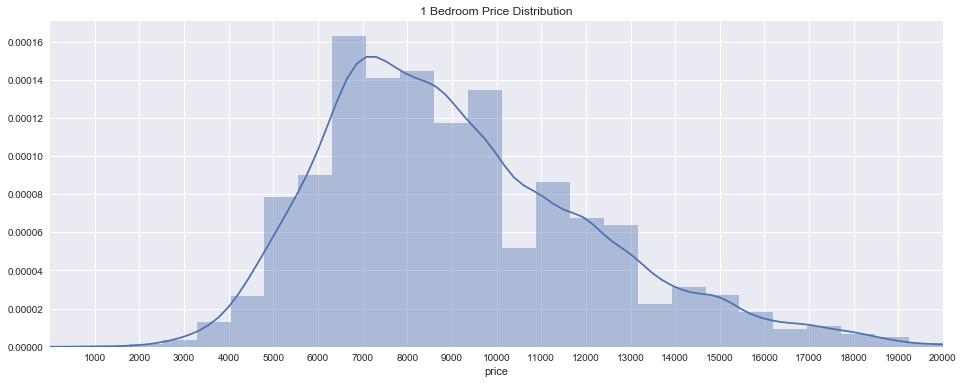

In [52]:
plt.figure(figsize=(16,6))
sns.set(color_codes=True)
sns.distplot(df.loc[(df['rooms_BR']==1) & (~df['posted_type'].isin(['Shared apartment','Service Apartment']))]['price'],bins=25)
plt.title("1 Bedroom Price Distribution")
plt.xticks(np.arange(1000,21000,1000))
plt.xlim(0,20000)
plt.show()

In [ ]:
pd.set_option('max_colwidth',1000)
df.loc[(df['price']>=20000) & 
              (df['rooms_BR']==1) & 
            (df['posted_type']=='Apartment for rent')][['price','description','size','area','posted_type']]

## Number of Listings

In [13]:
from bokeh.palettes import viridis,RdBu,Viridis256
from bokeh.models import ColorBar, LogColorMapper
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10

geo_source = GeoJSONDataSource(geojson=df_dist_d.to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Smartshanghai Postings',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>District</b>: @TITLE</div>'
              '<div><b>Number Listings</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
# fig.formatter.use_scientific = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

No handlers could be found for logger "/usr/local/lib/python2.7/site-packages/bokeh/core/validation/check.pyc"


## Apartment Vs LaoFang Likelihood

In [14]:
color_mapper = LinearColorMapper(RdBu[11])

fig = figure(title='Apartment Building Likelihood',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, 
            source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count']>25].to_json()), 
            color={'field': 'perc_laofang', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, 
            source=GeoJSONDataSource(geojson=df_dist_d.loc[df_dist_d['count']<=25].to_json()), 
            color='lightgray', 
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3], legend='Not Enough Listings to Compare')
hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>District</b>: @TITLE</div>'
              '<div><b>Percent LaoFang</b>: @perc_laofang_text</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
# fig.formatter.use_scientific = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

## Median 1 BR Price

In [21]:
# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Median 1 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, 
            source=GeoJSONDataSource(geojson=df_dist_d.loc[(df_dist_d['count_1br']>30) & 
                                                           (df_dist_d['TITLE']!='Tiantong Rd')].to_json()), 
            color={'field': 'median_1br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, 
            source=GeoJSONDataSource(geojson=df_dist_d.loc[(df_dist_d['count_1br']<=30)  |
                                                           (df_dist_d['TITLE']=='Tiantong Rd')].to_json()), 
            color='lightgray', legend='Not Enough Listings to Compare',
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Median 1BR Price','@median_1br_text'),
             ('',''),
#               ('10th Percentile','@percentile_10_1br_text'),
#               ('25th Percentile','@percentile_25_1br_text'),
#              ('50th Percentile','@median_1br_text'),
#              ('75th Percentile','@percentile_75_1br_text'),
#              ('90th Percentile','@percentile_90_1br_text'),
             ('Number Listings','@count_1br')
             ]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

NameError: name 'LogColorMapper' is not defined

In [24]:
df.loc[(df.district_dense=='Nanjing Pedestrian Street') & df['rooms_BR']==1][['price','listing_id','posted_type']].sort_values('listing_id')

,price,listing_id,posted_type
400,11800,862680,Apartment for rent
1772,26000,864052,Apartment for rent
1938,3200,864218,Shared apartment
2291,12000,864571,Apartment for rent
2437,3500,864717,Shared apartment
2851,6500,865131,Apartment for rent
3077,8500,865357,Apartment for rent
3456,3800,865736,Shared apartment
3668,3000,865948,Shared apartment
4028,12000,866308,Apartment for rent


## Median 2BR Price

In [137]:
# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Median 2 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[
    (df_dist_d['count_2br']>=30) & (df_dist_d['TITLE']!='Tiantong Rd')].to_json()), 
            color={'field': 'median_2br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(
    geojson=df_dist_d.loc[(df_dist_d['count_2br']<50) | (df_dist_d['TITLE']=='Tiantong Rd')].to_json()), 
            color='lightgray',  legend='Not Enough Listings to Compare',
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Median 2BR Price','@median_2br_text'),
             ('',''),
                          ('Number Listings','@count_2br')]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

## Median 3BR Price

In [138]:
# df_dist_d.loc[df_dist_d['count_1br']<50,['mean_1br']]=None
# geo_source = GeoJSONDataSource(geojson=df_dist_d.loc[temp_df['count_1br']>=25].to_json())

# color_mapper = LogColorMapper(viridis(256))
color_mapper = LogColorMapper(RdBu[11])

fig = figure(title='Median 3 Bedroom Price',plot_width=1000, plot_height=700)
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(geojson=df_dist_d.loc[
    (df_dist_d['count_3br']>=30)].to_json()), 
            color={'field': 'median_3br', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')
fig.patches(xs='xs', ys='ys', alpha=0.9, source=GeoJSONDataSource(
    geojson=df_dist_d.loc[(df_dist_d['count_3br']<50)].to_json()), 
            color='lightgray',  legend='Not Enough Listings to Compare',
            line_width=1, line_alpha=0.5, line_color='firebrick',line_dash = [6, 3])


hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=[('District','@TITLE'),
              ('Median 3BR Price','@median_3br_text'),
             ('',''),
                          ('Number Listings','@count_3br')]
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

# figures['tip-fraction'] = fig

show(fig)

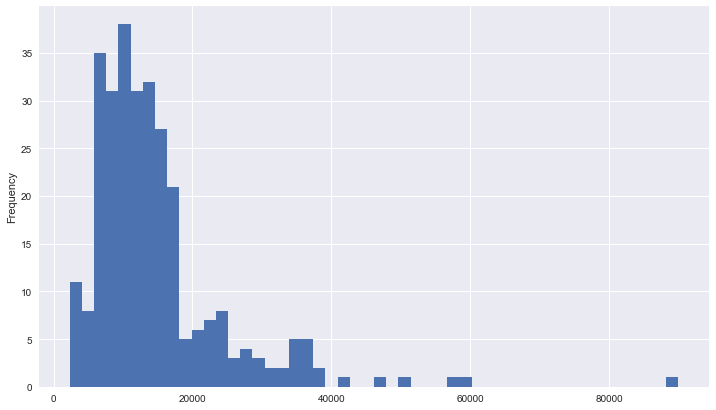

In [64]:
plt.figure(figsize=(12,7))
df.loc[df['publish_date'] == dt(2017,6,11).date()]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[1])
sns.distplot(df.loc[df['publish_week'] == weeks[1]]['price'], bins=50, kde=False)
plt.show()

In [ ]:
import seaborn as sns
sns.set(color_codes=True)

plt.figure(figsize=(12,7))
plt.title('Week: %s' % weeks[4])
for i in xrange(1,4): #df['rooms_BR'].value_counts()[0:3].index:
    print i
    sns.distplot(df.loc[df['publish_week'] == weeks[4]].loc[df['rooms_BR']==i]['price'], bins=20, kde=False,label=str(i));
#     df.loc[df['publish_week'] == weeks[1]].loc[df['rooms_simple']==type]['price'].plot.hist(bins=50)
# df.hist(column='price',bins=50,by='rooms_simple')
# sns.distplot(df.loc[df['publish_week'] == weeks[1]].loc[~df['rooms_simple'].isin(top4_rooms)]['price'], bins=50, kde=False,label="other")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,7))  
def update(i):
    plt.cla()

    plt.title('Week: {0}'.format(weeks[i]), fontsize=20)
    dfshow = df.loc[df['publish_week'] == weeks[i]]
    if not dfshow.empty:
        dfshow['price'].plot.hist(bins=50)

anim = FuncAnimation(fig, update, frames=np.arange(0,len(weeks)), interval=2000)

anim.save('line.gif', dpi=80, writer='imagemagick')

In [ ]:
import os
os.getcwd()

In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==6]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
df.loc[df['pub_month']==9]['price'].plot.hist(bins=50)
plt.show()

In [ ]:
900*20